In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2

In [230]:
class convnet(nn.Module):
    
    def __init__(self, input_size, filter_number, filter_size, training_size, alpha = 0.0001):
        super(convnet, self).__init__()
        self.input_size = input_size
        self.filter_number = filter_number
        self.filter_size = filter_size
        self.training_size = training_size
        self.alpha = alpha
        self.dimensions = self.input_size - self.filter_size + 1
        
        self.conv1 = nn.Conv2d(1, self.filter_number, self.filter_size)
        self.conv1.weight.data = self.init_weights()
        self.conv1.bias = torch.nn.Parameter(torch.zeros(self.filter_number))
        
        self.fc1 = nn.Linear(self.dimensions*self.dimensions*self.filter_number, 2)
        self.fc1.weight = torch.nn.Parameter(torch.zeros((2,self.dimensions*self.dimensions*self.filter_number)))
        
    def generate_gabor(self, size, theta):
        ksize = size
        sigma = 3
        lamda = 5
        gamma = 0.5
        phi = 0
        kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi)
        return torch.tensor(kernel).view(1, 1, size, size).float()
        
    def init_weights(self):
        angles = self.remove_ambiguous_stimuli(0, np.pi, self.filter_number)
        weights = []
        for i in range(self.filter_number):
            theta = angles[i]
            kernel = self.generate_gabor(self.filter_size, theta)
            weights.append(kernel)
        weight = torch.stack(weights).view(self.filter_number, 1, self.filter_size, self.filter_size)
        return weight
    
    def remove_ambiguous_stimuli(self, angle1, angle2, size):
        x = np.linspace(angle1, angle2, size)
        stimuli = [-np.pi/2, 0, np.pi/2, np.pi]
        ambiguous = True
        while ambiguous == True:
            for i in stimuli:
                x = np.where(x == i, i+0.001, x)
            x = np.linspace(x[0], x[-1], size)
            if -np.pi/2 in x or 0 in x or np.pi/2 in x:
                ambiguous = True
            else:
                ambiguous = False
        return x
                
    def inputting(self, angle1, angle2, double = False):
        
        self.labels = []
        self.inputs = []
        
        if double == False:
            x = self.remove_ambiguous_stimuli(angle1, angle2, self.training_size)

        elif double == True:
            x1 = self.remove_ambiguous_stimuli(-angle2, -angle1, self.training_size)
            x2 = self.remove_ambiguous_stimuli(angle1, angle2, self.training_size)
            x = np.concatenate((x1, x2))
            
        for i in range(self.training_size):
            theta = x[i]
            kernel = self.generate_gabor(self.input_size, theta)
            self.inputs.append(kernel)
            if 0 < theta < np.pi/2:
                label = torch.tensor([0])
            else:
                label = torch.tensor([1])
            self.labels.append(label)
        self.input = torch.stack(self.inputs).view(self.training_size, 1, self.input_size, self.input_size)
        return self.input
        
    
    def desired_outputting(self):
        self.desired_output = torch.tensor(self.labels)
        return self.desired_output
    
    def forward(self, x):
        result = self.conv1(x)
        out = result.view(1, self.dimensions*self.dimensions*self.filter_number)
        out = self.fc1(out)
        return out

    def loss(self, scores, desired_output):
        loss = torch.linalg.norm(desired_output - scores)**2
        return loss
    
    def binary_loss(self, scores, desired_output):
        loss = nn.CrossEntropyLoss()
        return loss(scores, desired_output)
    
    def train(self, iterations, optimizer):
        self.losses = []
        for i in range(iterations):
            optimizer.zero_grad()
            scores = self.forward(self.input)
            loss = self.loss(scores, self.desired_output)
            self.losses.append(loss)   
            loss.backward()
            optimizer.step()
    
    def mean_train(self, iterations, optimizer, test_angle, test_size):
        self.before_v1weight = self.conv1.weight.clone()
        self.before_w32weight = self.fc1.weight.clone()
        
        self.before_v1weights = []
        self.before_w32weights = []
        
        self.losses = []
        self.training_scores = []
        self.generalize_error = []
        self.generalize_perform = []
        for i in range(iterations):
            self.training_score = 0
            loss2 = []
            
            for j in range(self.training_size):
                optimizer.zero_grad()
                self.scores = self.forward(self.input[j][0].view(1, 1, self.input_size, self.input_size))
                loss1 = self.binary_loss(self.scores, self.desired_output[j].view(1))
                if torch.argmax(self.scores) == self.desired_output[j]:
                    self.training_score += 1
                loss2.append(loss1)
                
            loss = np.sum(loss2)/self.training_size
            self.losses.append(loss)
            
            self.training_score = self.training_score/self.training_size * 100
            self.training_scores.append(self.training_score)
            
            generalize = self.generalization(test_angle, test_size)
            self.generalize_error.append(self.general_mean_error)
            self.generalize_perform.append(self.generalization_score)
            
            self.before_v1weights.append(self.v1_weight_change(self.before_v1weight, self.conv1.weight))
            self.before_w32weights.append(self.w32_weight_change(self.before_w32weight, self.fc1.weight))
            
            loss.backward()
            optimizer.step()
            
    def double_train(self, iterations, optimizer, angle1, angle2, test_angle, test_size):        
        self.before_v1weight = self.conv1.weight.clone()
        self.before_w32weight = self.fc1.weight.clone()
        
        self.before_v1weights = []
        self.before_w32weights = []
        
        self.losses = []
        self.training_scores = []
        self.generalize_error = []
        self.generalize_perform = []
        for angle in [angle1, angle2]:
            input = self.inputting(-angle, angle, double = False)
            desired_output = self.desired_outputting()
            for i in range(iterations):
                self.training_score = 0
                loss2 = []

                for j in range(self.training_size):
                    optimizer.zero_grad()
                    self.scores = self.forward(input[j][0].view(1, 1, self.input_size, self.input_size))
                    loss1 = self.binary_loss(self.scores, desired_output[j].view([1]))
                    if torch.argmax(self.scores) == desired_output[j]:
                        self.training_score += 1
                    loss2.append(loss1)

                loss = np.sum(loss2)/self.training_size
                self.losses.append(loss)

                self.training_score = self.training_score/self.training_size * 100
                self.training_scores.append(self.training_score)

                generalize = self.generalization(test_angle, test_size)
                self.generalize_error.append(self.general_mean_error)
                self.generalize_perform.append(self.generalization_score)

                self.before_v1weights.append(self.v1_weight_change(self.before_v1weight, self.conv1.weight))
                self.before_w32weights.append(self.w32_weight_change(self.before_w32weight, self.fc1.weight))

                loss.backward()
                optimizer.step()
        
    
    def plot_training_error(self, color):
        plt.plot(self.losses, color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Error")

    def plot_training_performance(self, color):
        plt.plot(self.training_scores, color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Performance (%)")
        
        
    def generalization(self, angle, test_size):
        angles = self.remove_ambiguous_stimuli(-angle, angle, test_size)
        self.generalization_score = 0
        general_error = []
        for i in range(test_size):
            gabor = net.generate_gabor(self.input_size, angles[i]).clone().detach()
            if 0 < angles[i] < np.pi/2:
                label = torch.tensor([0])
            else:
                label = torch.tensor([1])
            with torch.no_grad():
                a = self.forward(gabor)
                if torch.argmax(a) == label:
                    self.generalization_score += 1
                general_error.append(self.binary_loss(a, label))
        self.generalization_score = self.generalization_score/test_size * 100
        self.general_mean_error = np.mean(general_error)

    def plot_generalization_performance(self, color):
        plt.plot(self.generalize_perform, color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Performance (%)")

    def plot_generalization_error(self, color):
        plt.plot(self.generalize_error, color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Error")
        
    def plot_angle_performance(self, number, color):
        angles = self.remove_ambiguous_stimuli(0, np.pi/2, number)
        scores = []
        for i in range(number):
            self.generalization(angles[i], 100)
            scores.append(self.generalization_score)
        plt.plot(2 * angles, scores, color = color)
        plt.xlabel("Separation angle (radians)")
        plt.ylabel("Performance (%)")
            
    def v1_weight_change(self, before, after):
        diff = after - before
        net_diff = []
        for i in diff:
            net_diff.append(torch.linalg.norm(i.view(self.filter_size, self.filter_size), ord = 'fro').item())
        return np.mean(net_diff)
    
    def w32_weight_change(self, before, after):
        diff = after - before
        net_diff = (torch.linalg.norm(
            diff.view(2, self.dimensions*self.dimensions*self.filter_number), ord = 'fro').item())
        return net_diff
    
    def plot_weight_change(self, color, v1 = False, w32 = False):
        if v1 == True:
            plt.plot(self.before_v1weights, color = color)
        if w32 == True:
            plt.plot(self.before_w32weights, color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Weight change")

In [239]:
net = convnet(33, 6, 11, 2, alpha = 0.0001)
x = net.inputting(-np.pi/4, np.pi/4, double = False)
y = net.desired_outputting()
optimizer = optim.SGD(net.parameters(), lr = net.alpha)
net.mean_train(100, optimizer, np.pi/16, 100)

net2 = convnet(33, 6, 11, 2, alpha = 0.0001)
x2 = net2.inputting(-np.pi/100, np.pi/100, double = False)
y2 = net2.desired_outputting()
optimizer = optim.SGD(net2.parameters(), lr = net2.alpha)
net2.mean_train(100, optimizer, np.pi/16, 100)


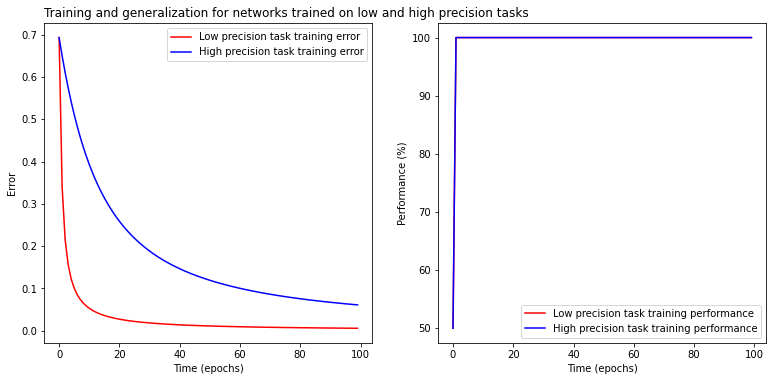

In [240]:
plt.figure(figsize = [20, 20])
plt.subplot(3, 3, 1)
net.plot_training_error('red')
# net.plot_generalization_error("maroon")
net2.plot_training_error('blue')
# net2.plot_generalization_error("darkblue")
plt.legend(["Low precision task training error",
            "High precision task training error"]);
plt.title("Training and generalization for networks trained on low and high precision tasks", loc = "left")

plt.subplot(3, 3, 2)
net.plot_training_performance('red')
# net.plot_generalization_performance("maroon")
net2.plot_training_performance('blue')
# net2.plot_generalization_performance("darkblue")
plt.legend(["Low precision task training performance",
            "High precision task training performance"]);


In [241]:
net3 = convnet(33, 6, 11, 2, alpha = 0.0001)
optimizer = optim.SGD(net3.parameters(), lr = net3.alpha)
net3.double_train(50, optimizer, np.pi/4, np.pi/100, np.pi/16, 100)

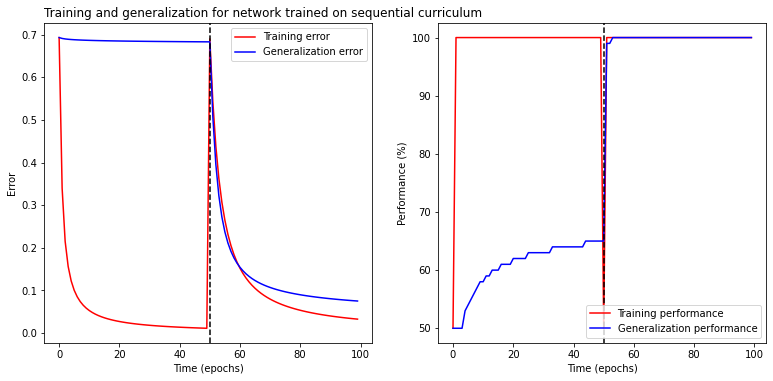

In [235]:
plt.figure(figsize = [20, 20])
plt.subplot(3, 3, 1)
net3.plot_training_error('red')
net3.plot_generalization_error("blue")
plt.axvline(50, 0, 1, linestyle = 'dashed', color = 'black');
plt.legend(["Training error", "Generalization error"]);
plt.title("Training and generalization for network trained on sequential curriculum", loc = "left")

plt.subplot(3, 3, 2)
net3.plot_training_performance('red')
net3.plot_generalization_performance("blue")
plt.legend(["Training performance", "Generalization performance"]);
plt.axvline(50, 0, 1, linestyle = 'dashed', color = 'black');


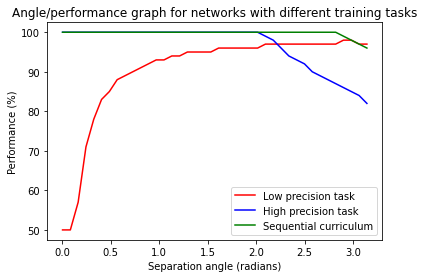

In [242]:
net.plot_angle_performance(40, 'red')
net2.plot_angle_performance(40, 'blue')
net3.plot_angle_performance(40, 'green')
plt.legend(["Low precision task", "High precision task", "Sequential curriculum"]);
plt.title("Angle/performance graph for networks with different training tasks", loc = 'center');

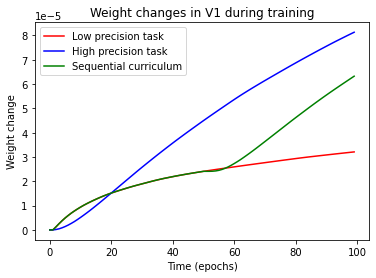

In [243]:
net.plot_weight_change('red', v1 = True)
net2.plot_weight_change('blue', v1 = True)
net3.plot_weight_change('green', v1 = True)
plt.legend(["Low precision task", "High precision task", "Sequential curriculum"]);
plt.title("Weight changes in V1 during training");

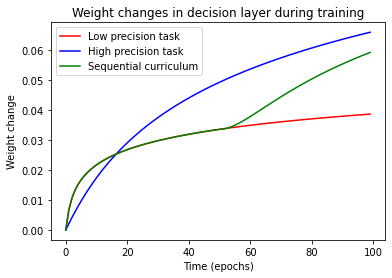

In [244]:
net.plot_weight_change('red', w32 = True)
net2.plot_weight_change('blue', w32 = True)
net3.plot_weight_change('green', w32 = True)
plt.legend(["Low precision task", "High precision task", "Sequential curriculum"]);
plt.title("Weight changes in decision layer during training");

In [ ]:
def calculate_score(angle, network):
    angles = np.linspace(-angle, angle, 1000)
    score_a = 0
    score_b = 0
    total = 0
    scores = []
    for i in range(len(angles)):
        gabor = net.generate_gabor(33, angles[i]).clone().detach()
        if 0 <= angles[i] <= np.pi/2:
                    label = 1
        else:
            label = -1
        with torch.no_grad():
            a = net.forward(gabor)
            b = net2.forward(gabor)
            scores.append(b.round().item())
            if a.round().item() == label:
                score_a += 1
            if b.round().item() == label:
                score_b += 1
        total += 1
    score_a = score_a/total * 100
    score_b = score_b/total * 100
#     print("Net1 score: " + str(score_a) + "%")
#     print("Net2 score: " + str(score_b) + "%")
    if network == net:
        return score_a 
    elif network == net2:
        return score_b 

In [ ]:
ascores = []
bscores = []
x = np.linspace(0, np.pi/2, 40)
for i in range(40):
    ascore = calculate_score(x[i], net)
    ascores.append(ascore)
#     bscore = calculate_score(x[i], net2)
#     bscores.append(bscore)
plt.plot(2*x, ascores, "red");
# plt.plot(2*x, bscores, "blue")
plt.xlabel("Task separation angle (radians)")
plt.ylabel("Performance (%)");
# plt.legend(["Trained on low precision task", "Trained on high precision task"]);

In [ ]:
gabor = net.generate_gabor(11, -np.pi/6).clone().detach()
with torch.no_grad():
    a = net.forward(gabor)
    print(a)

In [ ]:
x = torch.randn(1, 1, 10, 10)

def generate_gabor(ksize, theta):
        ksize = 5
        sigma = 1
        lamda = np.pi/4
        gamma = 0.1
        phi = 0
        kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi)
        return torch.tensor(kernel).view(1, 1, 5, 5).float()
# maps = []
# angles = np.linspace(0, np.pi, 3)
# for i in range(3):
#     theta = angles[i]
#     kernel = generate_gabor(theta)
#     out = F.conv2d(x, kernel)
#     maps.append(out)
# a = []
# len(maps)


In [ ]:
net = convnet(11, 3, 5, 3)
x = np.linspace(0, np.pi, 3)
inputs = []
b = net.input(0, np.pi/2)

def init_weights(n):
    for i in range(n):
        theta = x[i]
        kernel = net.generate_gabor(5, theta)
        inputs.append(kernel)
    input = torch.stack(inputs).view(1, n, 5, 5)
    return input

conv1 = torch.nn.Conv2d(1, 3, 11, 11)
a = init_weights(3)
conv1.weight.data = a
maps = []
for i in range(net.training_size):
    input = b[0][i].view(1, 1, 11, 11)
    weight = conv1.weight.data[0][i].view(1, 1, 5, 5)
    result = F.conv2d(input, weight)
    maps.append(result)
    
maps

In [ ]:
sigma = nn.Parameter(torch.randn(1), requires_grad = True)


In [ ]:
net = convnet(11, 30, 5, 20)
a = net.input(0, np.pi/2)
def init_weights(n):
    inputs = []
    for i in range(n):
            theta = x[i]
            kernel = net.generate_gabor(11, theta)
            inputs.append(kernel)
#     b = torch.stack(inputs).view(1, n, 11, 11)
    return inputs
conv1 = torch.nn.Conv2d(1, 3, 5, 5)
a = init_weights(3)
# for i in range(len(inputs)):
#     result = conv1(a[i])
#     print(result)
a

In [ ]:
net = convnet(33, 30, 11, 20, alpha = 0.001)
x = net.input(-np.pi/2,np.pi/2).view(-1, 1, 11, 11)
y = net.desired_output()
optimizer = optim.SGD(net.parameters(), lr = net.alpha)
net(x)

In [ ]:
b = torch.randn(3, 5, 5).view(3, 1, 5, 5)
a = nn.Conv2d(1, 3, 2)
a.weight.shape

In [ ]:
x = np.linspace(-np.pi/2, np.pi/2, 10)
ignore = 0
ambiguous = True
while ambiguous == True:
    if -np.pi/2 in x:
        ignore += 1
        np.delete(x, theta)
    if 0 in x:
        ignore += 1
        np.delete(x, theta)
    if np.pi/2 in x:
        ignore += 1
        np.delete(x, theta)
    x = np.linspace(x[0], x[-1], self.training_size)
    if -np.pi/2 in x or 0 in x or np.pi/2 in x:
        ambiguous = True
    else:
        ambiguous = False

In [362]:
ksize = 11
sigma = 3
lamda = 5
gamma = 0.5
theta = np.pi/3
phi = 0
kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi)
torch.linalg.norm(torch.tensor(kernel).view(11, 11), ord = 'fro')

tensor(4.8255, dtype=torch.float64)

In [235]:
x = np.linspace(0, np.pi/2, 5)
y = x[np.ix_(*[range(1, i, 2) for i in x.shape])]
x, y

(array([0.        , 0.39269908, 0.78539816, 1.17809725, 1.57079633]),
 array([0.39269908, 1.17809725]))

In [ ]:
class convnet(nn.Module):
    
    def __init__(self, input_size, filter_number, filter_size, training_size, alpha = 0.0001):
        super(convnet, self).__init__()
        self.input_size = input_size
        self.filter_number = filter_number
        self.filter_size = filter_size
        self.training_size = training_size
        self.alpha = alpha
        self.dimensions = self.input_size - self.filter_size + 1
        
        self.conv1 = nn.Conv2d(1, self.filter_number, self.filter_size)
        self.conv1.weight.data = self.init_weights()
        self.conv1.bias = torch.nn.Parameter(torch.zeros(self.filter_number))
        
        self.fc1 = nn.Linear(self.dimensions*self.dimensions*self.filter_number, 1)
        self.fc1.weight = torch.nn.Parameter(torch.zeros((1,self.dimensions*self.dimensions*self.filter_number)))
        
    def generate_gabor(self, size, theta):
        ksize = size
        sigma = 3
        lamda = 5
        gamma = 0.5
        phi = 0
        kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi)
        return torch.tensor(kernel).view(1, 1, size, size).float()
        
    def init_weights(self):
        angles = self.remove_ambiguous_stimuli(0, np.pi, self.filter_number)
        weights = []
        for i in range(self.filter_number):
            theta = angles[i]
            kernel = self.generate_gabor(self.filter_size, theta)
            weights.append(kernel)
        weight = torch.stack(weights).view(self.filter_number, 1, self.filter_size, self.filter_size)
        return weight
    
    def remove_ambiguous_stimuli(self, angle1, angle2, size):
        x = np.linspace(angle1, angle2, size)
        stimuli = [-np.pi/2, 0, np.pi/2, np.pi]
        ambiguous = True
        while ambiguous == True:
            for i in stimuli:
                x = np.where(x == i, i+0.001, x)
            x = np.linspace(x[0], x[-1], size)
            if -np.pi/2 in x or 0 in x or np.pi/2 in x:
                ambiguous = True
            else:
                ambiguous = False
        return x
                
    def inputting(self, angle1, angle2, double = False):
        
        self.labels = []
        self.inputs = []
        
        if double == False:
            x = self.remove_ambiguous_stimuli(angle1, angle2, self.training_size)

        elif double == True:
            x1 = self.remove_ambiguous_stimuli(-angle2, -angle1, self.training_size)
            x2 = self.remove_ambiguous_stimuli(angle1, angle2, self.training_size)
            x = np.concatenate((x1, x2))
            
        for i in range(self.training_size):
            theta = x[i]
            kernel = self.generate_gabor(self.input_size, theta)
            self.inputs.append(kernel)
            if 0 < theta < np.pi/2:
                label = 1
            else:
                label = -1
            self.labels.append(label)
        self.input = torch.stack(self.inputs).view(self.training_size, 1, self.input_size, self.input_size)
        return self.input
        
    
    def desired_outputting(self):
        self.desired_output = torch.tensor(self.labels)
        return self.desired_output
    
    def forward(self, x):
        result = self.conv1(x)
        out = result.view(1, self.dimensions*self.dimensions*self.filter_number)
        out = self.fc1(out)
        return out

    def loss(self, scores, desired_output):
        loss = torch.linalg.norm(desired_output - scores)**2
        return loss
    
    def train(self, iterations, optimizer):
        self.losses = []
        for i in range(iterations):
            optimizer.zero_grad()
            scores = self.forward(self.input)
            loss = self.loss(scores, self.desired_output)
            self.losses.append(loss)   
            loss.backward()
            optimizer.step()
    
    def mean_train(self, iterations, optimizer, test_angle, test_size):
        self.before_v1weight = self.conv1.weight.clone()
        self.before_w32weight = self.fc1.weight.clone()
        
        self.before_v1weights = []
        self.before_w32weights = []
        
        self.losses = []
        self.training_scores = []
        self.generalize_error = []
        self.generalize_perform = []
        for i in range(iterations):
            self.training_score = 0
            loss2 = []
            
            for j in range(self.training_size):
                optimizer.zero_grad()
                self.scores = self.forward(self.input[j][0].view(1, 1, self.input_size, self.input_size))
                loss1 = self.loss(self.scores, self.desired_output[j])
                if self.scores.round() == self.desired_output[j]:
                    self.training_score += 1
                loss2.append(loss1)
                
            loss = np.sum(loss2)/self.training_size
            self.losses.append(loss)
            
            self.training_score = self.training_score/self.training_size * 100
            self.training_scores.append(self.training_score)
            
            generalize = self.generalization(test_angle, test_size)
            self.generalize_error.append(self.general_mean_error)
            self.generalize_perform.append(self.generalization_score)
            
            self.before_v1weights.append(self.v1_weight_change(self.before_v1weight, self.conv1.weight))
            self.before_w32weights.append(self.w32_weight_change(self.before_w32weight, self.fc1.weight))
            
            loss.backward()
            optimizer.step()
            
    def double_train(self, iterations, optimizer, angle1, angle2, test_angle, test_size):        
        self.before_v1weight = self.conv1.weight.clone()
        self.before_w32weight = self.fc1.weight.clone()
        
        self.before_v1weights = []
        self.before_w32weights = []
        
        self.losses = []
        self.training_scores = []
        self.generalize_error = []
        self.generalize_perform = []
#         for angle in [angle1, angle2]:
# train 1
        input = self.inputting(angle1, angle2, double = True)
        desired_output = self.desired_outputting()
        for i in range(iterations):
            self.training_score = 0
            loss2 = []

            for j in range(self.training_size):
                optimizer.zero_grad()
                self.scores = self.forward(input[j][0].view(1, 1, self.input_size, self.input_size))
                loss1 = self.loss(self.scores, desired_output[j])
                if self.scores.round() == desired_output[j]:
                    self.training_score += 1
                loss2.append(loss1)

            loss = np.sum(loss2)/self.training_size
            self.losses.append(loss)

            self.training_score = self.training_score/self.training_size * 100
            self.training_scores.append(self.training_score)

            generalize = self.generalization(test_angle, test_size)
            self.generalize_error.append(self.general_mean_error)
            self.generalize_perform.append(self.generalization_score)
            
            self.before_v1weights.append(self.v1_weight_change(self.before_v1weight, self.conv1.weight))
            self.before_w32weights.append(self.w32_weight_change(self.before_w32weight, self.fc1.weight))
            
            loss.backward()
            optimizer.step()
        
# train 2
        
        input = self.inputting(-angle1, angle1, double = False)
        desired_output = self.desired_outputting()

        for i in range(iterations):
            self.training_score = 0
            loss2 = []

            for j in range(self.training_size):
                optimizer.zero_grad()
                self.scores = self.forward(input[j][0].view(1, 1, self.input_size, self.input_size))
                loss1 = self.loss(self.scores, desired_output[j])
                if self.scores.round() == desired_output[j]:
                    self.training_score += 1
                loss2.append(loss1)

            loss = np.sum(loss2)/self.training_size
            self.losses.append(loss)

            self.training_score = self.training_score/self.training_size * 100
            self.training_scores.append(self.training_score)

            generalize = self.generalization(test_angle, test_size)
            self.generalize_error.append(self.general_mean_error)
            self.generalize_perform.append(self.generalization_score)

            self.before_v1weights.append(self.v1_weight_change(self.before_v1weight, self.conv1.weight))
            self.before_w32weights.append(self.w32_weight_change(self.before_w32weight, self.fc1.weight))
            
            loss.backward()
            optimizer.step()
    
    
    def plot_training_error(self, color):
        plt.plot(self.losses, color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Error")

    def plot_training_performance(self, color):
        plt.plot(self.training_scores, color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Performance (%)")
        
        
    def generalization(self, angle, test_size):
        angles = self.remove_ambiguous_stimuli(-angle, angle, test_size)
        self.generalization_score = 0
        general_error = []
        for i in range(test_size):
            gabor = net.generate_gabor(self.input_size, angles[i]).clone().detach()
            if 0 < angles[i] < np.pi/2:
                label = 1
            else:
                label = -1
            with torch.no_grad():
                a = self.forward(gabor)
                if a.round().item() == label:
                    self.generalization_score += 1
                general_error.append(self.loss(a, label))
        self.generalization_score = self.generalization_score/test_size * 100
        self.general_mean_error = np.mean(general_error)

    def plot_generalization_performance(self, color):
        plt.plot(self.generalize_perform, color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Performance (%)")

    def plot_generalization_error(self, color):
        plt.plot(self.generalize_error, color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Error")
        
    def plot_angle_performance(self, number, color):
        angles = self.remove_ambiguous_stimuli(0, np.pi/2, number)
        scores = []
        for i in range(number):
            self.generalization(angles[i], 500)
            scores.append(self.generalization_score)
        plt.plot(2 * angles, scores, color = color)
        plt.xlabel("Separation angle (radians)")
        plt.ylabel("Performance (%)")
            
    def v1_weight_change(self, before, after):
        diff = after - before
        net_diff = []
        for i in diff:
            net_diff.append(torch.linalg.norm(i.view(11, 11), ord = 'fro').item())
        return np.mean(net_diff)
    
    def w32_weight_change(self, before, after):
        diff = after - before
        net_diff = []
        for i in diff:
            net_diff.append(torch.linalg.norm(i).item())
        return np.mean(net_diff)
    
    def plot_weight_change(self, color, v1 = False, w32 = False):
        if v1 == True:
            plt.plot(self.before_v1weights, color = color)
        if w32 == True:
            plt.plot(self.before_w32weights, color = color)
        plt.xlabel("Time (epochs)")
        plt.ylabel("Weight change")

In [22]:
input = torch.tensor([[0.7, 0.3], [0.4, 0.5]])
output = nn.Softmax(dim = 1)
a = output(input)

input, a

(tensor([[0.7000, 0.3000],
         [0.4000, 0.5000]]),
 tensor([[0.5987, 0.4013],
         [0.4750, 0.5250]]))

In [35]:
input = torch.tensor([6]).float()
output = nn.Softmax()
a = torch.sigmoid(input)

input, a

(tensor([6.]), tensor([0.9975]))

In [145]:
loss = nn.CrossEntropyLoss()
input = torch.tensor([5, -4]).view(1, 2).float()
target = torch.tensor([0]).view(1)
output = loss(input, target)
input, target, output
torch.argmax(input)

tensor(0)